# Feature Importance

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
from sklearn.linear_model import Lasso
from sklearn.metrics import silhouette_score

import IPython

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

import plotly.graph_objects as go

#%matplotlib ipympl

In [77]:
def echo(df):
    print(df)
    return df
EchoTransformer = FunctionTransformer(echo)

def custom_date_transform(df):
    out = pd.DataFrame()
    for col in df.columns:
        out[col] = df[col].dt.year + ((df[col].dt.month-1)/12)
    return out
CustomDateTransformer = FunctionTransformer(custom_date_transform)

def zero_to_na_transform(df):
    return df[['price', 'reviews']].replace(0, np.nan)
ZeroToNaTransformer = FunctionTransformer(zero_to_na_transform)

def wrap_model(scaler=StandardScaler, encoder=lambda:OneHotEncoder(sparse_output=False), imputer=lambda:SimpleImputer(strategy="median"), transformers=[], poly=False, output=None):
    def inner(model):
        return make_pipeline(
            *transformers,
            make_column_transformer(
                (
                    make_pipeline(
                        *([imputer().set_output(transform=output) if imputer else []]),
                        scaler().set_output(transform=output),
                    ), make_column_selector(dtype_include=[np.number, bool])
                ),
                (
                    make_pipeline(
                        CustomDateTransformer,
                        *([imputer().set_output(transform=output) if imputer else []]),
                        scaler().set_output(transform=output),
                    ), make_column_selector(dtype_include='datetime')
                ),
                (encoder().set_output(transform=output), make_column_selector(dtype_include=object)),
            ).set_output(transform=output),
            model
        ).set_output(transform=output)
    return inner

def pt_pipeline():
    return make_pipeline(
        StandardScaler(),
        PowerTransformer()
    )

def scatter3D(df,x,y,z,hue):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    for h in np.unique(hue):
        gdf = df[hue==h]
        ax1.scatter(gdf[x],gdf[y],gdf[z],label=h)
        ax1.set_xlabel(x)
        ax1.set_ylabel(y)
        ax1.set_zlabel(z)
    """
    ax2 = fig.add_subplot(122)
    for h in np.unique(hue):
        gdf = df[hue==h]
        plt.scatter(gdf[x],gdf[y],label=h)
    """
    return ax1

def cluster_visualize(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    km = preprocess(cluster).fit(X)
    groups = km[-1].labels_
    
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')

def cluster_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    return groups

def cluster_visualize_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')


In [83]:
dataset = pd.read_csv('kindle_data-v2.csv')

df = dataset.drop(['asin', 'imgUrl', 'productURL', 'category_id'], axis=1)
df.publishedDate = pd.to_datetime(dataset.publishedDate)

X = df.drop(['title', 'author', 'soldBy'], axis=1).copy()
X['soldByAmazon'] = df.soldBy.str.contains('Amazon').astype(bool)
X

# Clipped and marked (marks disabled)
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

#X2.reviews.replace(0, np.nan, inplace=True)
#X2.price.replace(0, np.nan, inplace=True)

X2.price = np.log1p(X2.price)
X2.reviews = np.log1p(X2.reviews)

# unbalanced boolean features removed
X3 = X2.select_dtypes(exclude=['bool']).copy()

In [111]:
X3.describe()

,stars,reviews,price,publishedDate
count,133102.000000,133102.000000,133102.000000,84086
mean,4.404090,2.579404,2.211725,2018-03-08 14:26:13.988535552
min,0.000000,0.000000,0.000000,2000-01-01 00:00:00
25%,4.400000,0.000000,1.790091,2015-02-15 00:00:00
50%,4.500000,1.609438,2.396986,2019-10-12 00:00:00
75%,4.700000,5.902633,2.771964,2022-06-07 00:00:00
max,5.000000,5.902633,2.772589,2024-01-16 00:00:00
std,0.745646,2.666774,0.620797,NaN


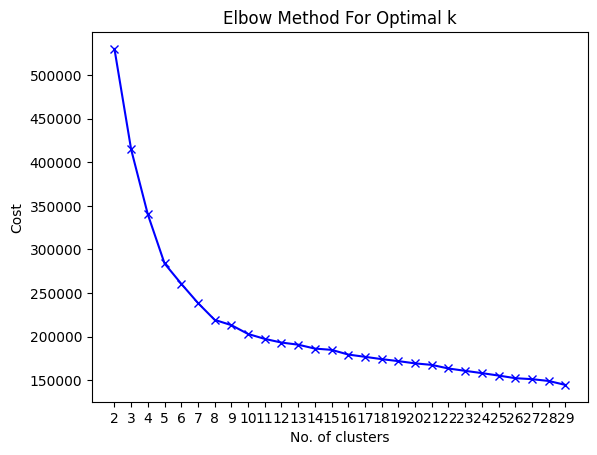

In [90]:
cost = []
K = list(range(2,30,1))
for num_clusters in K:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='random')
    wrap_model(StandardScaler)(km).fit(X3)
    cost.append(km.inertia_)

plt.figure()
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.xticks(K)
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


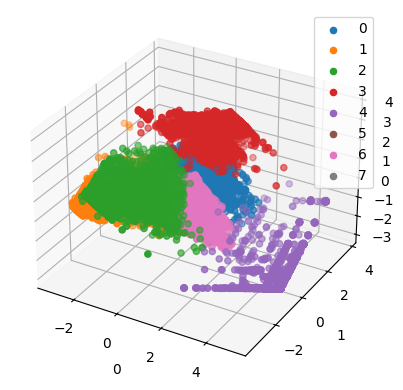

In [125]:
km = KMeans(n_clusters=8)
cluster_visualize(X3, cluster=km, pca_dims=3,
                  preprocess=wrap_model(StandardScaler))
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

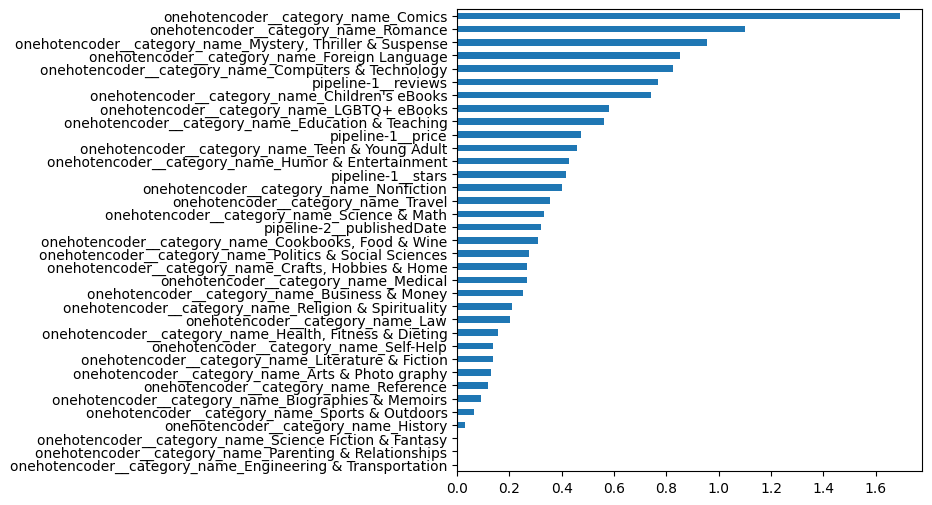

In [222]:
columns = list(wrap_model(output='pandas')(None)[:-1].fit_transform(X3).columns)

km = wrap_model(output='pandas')(KMeans(n_clusters=8)).fit(X3)
lasso = wrap_model()(Lasso(alpha=0.0001))

lasso.fit(X3, km[-1].labels_)
lasso_coef = np.abs(lasso[-1].coef_)

coefs = pd.Series(lasso_coef, index=columns).sort_values()
plt.figure(figsize=(6,6))
coefs.plot.barh()


In [228]:
silhouette_score(km[:-1].transform(X3), km[-1].labels_)

0.22235166971968798

## Metacategories

In [150]:
Lifestyle = [ 'Parenting & Relationships', 'Sports & Outdoors', 'Health, Fitness & Dieting', 'Self-Help', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home' ]
Stories = [ "Children's eBooks", 'Mystery, Thriller & Suspense', 'Literature & Fiction',  'Biographies & Memoirs', 'Teen & Young Adult', 'Travel', 'LGBTQ+ eBooks', 'Religion & Spirituality', 'Comics', 'Arts & Photo graphy', 'Science Fiction & Fantasy', 'Nonfiction', 'Romance', 'Humor & Entertainment']
Educational = ['Engineering & Transportation', 'Science & Math','Computers & Technology', 'Politics & Social Sciences', 'Foreign Language', 'Education & Teaching', 'History', 'Reference', 'Medical', 'Business & Money', 'Law' ]

map = {}
map.update({val: 'Lifestyle' for val in Lifestyle})
map.update({val: 'Stories' for val in Stories})
map.update({val: 'Educational' for val in Educational})

X4 = X3.copy().drop('category_name', axis=1)
X4['category'] = X3.category_name.map(map)
X4.category.isna().sum()

0

In [170]:
X4.category.value_counts()

category
Stories        59924
Educational    48158
Lifestyle      25020
Name: count, dtype: int64

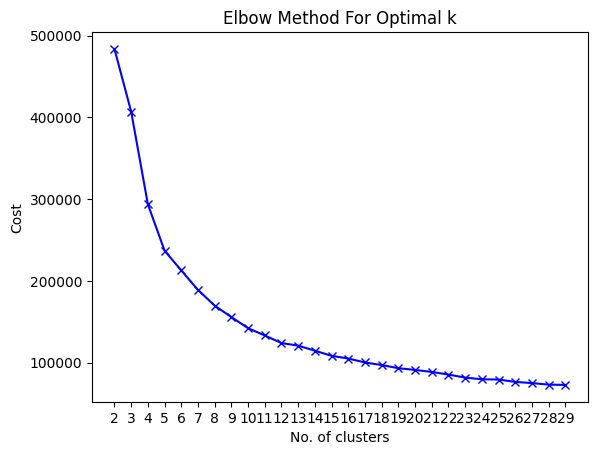

In [153]:
cost = []
K = list(range(2,30,1))
for num_clusters in K:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='random')
    wrap_model(StandardScaler)(km).fit(X4)
    cost.append(km.inertia_)

plt.figure()
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.xticks(K)
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


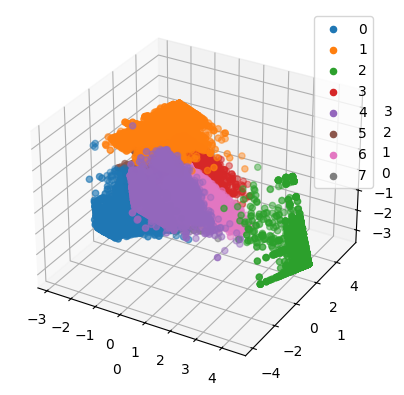

In [172]:
km = KMeans(n_clusters=8)
cluster_visualize(X4, cluster=km, pca_dims=3,
                  preprocess=wrap_model(StandardScaler))
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


<Axes: >

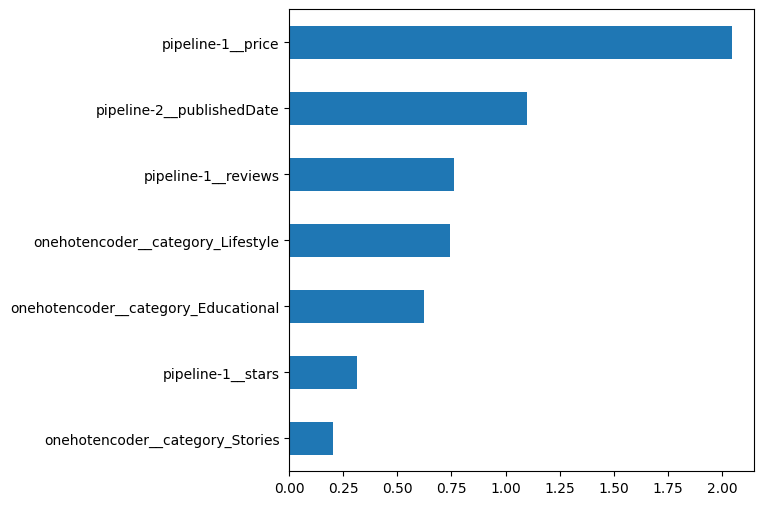

In [229]:
columns = list(wrap_model(output='pandas')(None)[:-1].fit_transform(X4).columns)

km = wrap_model(output='pandas')(KMeans(n_clusters=12, n_init='auto')).fit(X4)
lasso = wrap_model()(Lasso(alpha=0.00001))

lasso.fit(X4, km[-1].labels_)
lasso_coef = np.abs(lasso[-1].coef_)

coefs = pd.Series(lasso_coef, index=columns).sort_values()
plt.figure(figsize=(6,6))
coefs.plot.barh()


In [230]:
silhouette_score(km[:-1].transform(X4), km[-1].labels_)

0.3281708654597539

## Author work count

In [205]:
X5 = X4.copy()
X5['authorWorks'] = np.log(df.author.map(df.author.value_counts().to_dict()).fillna(1).astype(int))
X5

,stars,reviews,price,publishedDate,category,authorWorks
0,4.8,0.0,2.396986,2015-06-01,Lifestyle,1.386294
1,4.4,0.0,2.772589,2022-02-15,Lifestyle,1.386294
2,4.8,0.0,2.772589,2022-09-13,Lifestyle,0.693147
3,4.2,0.0,2.393339,2020-02-25,Lifestyle,1.098612
4,4.7,0.0,2.707383,2015-05-05,Lifestyle,1.609438
...,...,...,...,...,...,...
133097,4.7,0.0,0.000000,2023-09-15,Stories,2.197225
133098,4.4,0.0,2.396986,2021-09-30,Stories,1.791759
133099,4.8,0.0,1.095273,2023-09-15,Stories,1.945910
133100,4.7,0.0,0.000000,2023-08-25,Stories,2.197225


In [208]:
X5.authorWorks.describe(percentiles=[0.90])

count    133102.000000
mean          1.087165
std           1.209715
min           0.000000
50%           0.693147
90%           2.890372
max           5.356586
Name: authorWorks, dtype: float64

In [209]:
X5.authorWorks.clip(upper=2.89, inplace=True)

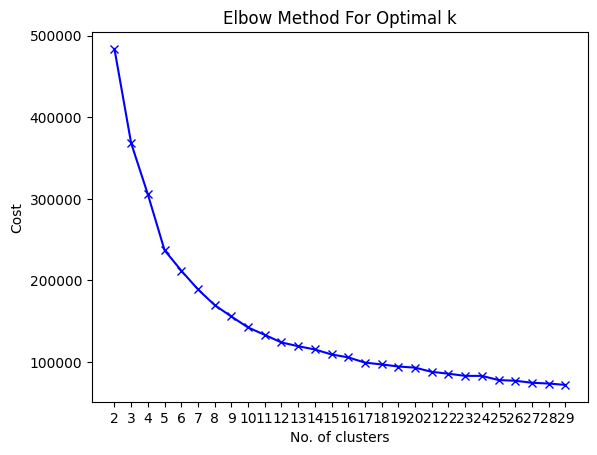

In [210]:
cost = []
K = list(range(2,30,1))
for num_clusters in K:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='random')
    wrap_model(StandardScaler)(km).fit(X4)
    cost.append(km.inertia_)

plt.figure()
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.xticks(K)
plt.title('Elbow Method For Optimal k')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


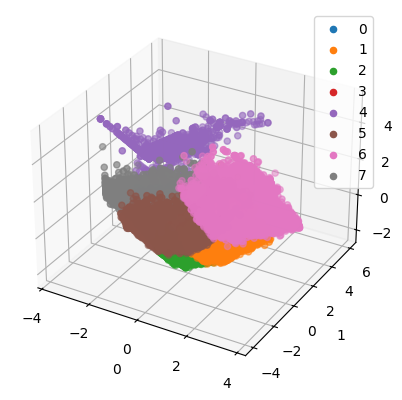

In [211]:
km = KMeans(n_clusters=8)
cluster_visualize(X5, cluster=km, pca_dims=3,
                  preprocess=wrap_model(StandardScaler))
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


<Axes: >

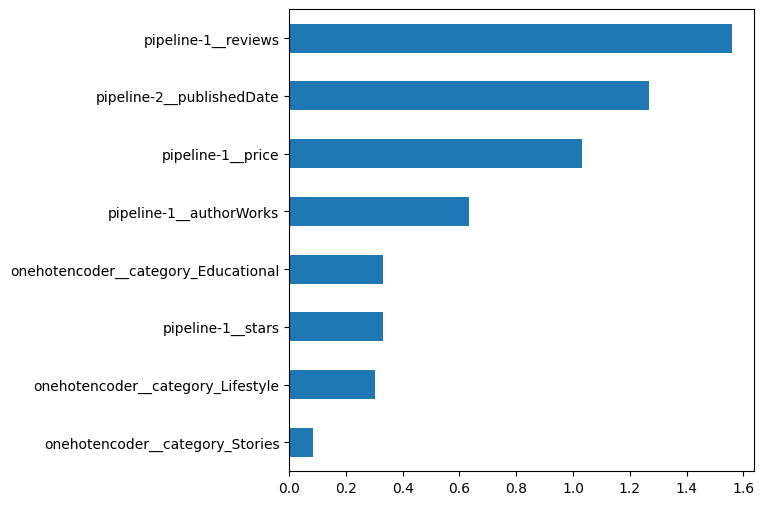

In [231]:
columns = list(wrap_model(output='pandas')(None)[:-1].fit_transform(X5).columns)

km = wrap_model(output='pandas')(KMeans(n_clusters=12, n_init='auto')).fit(X5)
lasso = wrap_model()(Lasso(alpha=0.00001))

lasso.fit(X5, km[-1].labels_)
lasso_coef = np.abs(lasso[-1].coef_)

coefs = pd.Series(lasso_coef, index=columns).sort_values()
plt.figure(figsize=(6,6))
coefs.plot.barh()


Lasso koeficijenti su previse varijabilni, pretpostavka je da su klasteri previse blizu jedni do drugih

In [232]:
silhouette_score(km[:-1].transform(X5), km[-1].labels_)

0.2669252759467174